In [0]:
##Author : Varnnitha Venugopal
##Master's in Computer Science with Big Data 
##Simon Fraser University, Burnaby
##Created on : April 12 2020

In [0]:
import numpy as np
import pandas as pd


In [0]:
#Isolation Forest
# spark-submit IForest_Lift1.py /home/techsafebc/EDS_1.csv.gz
#packages
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

from pyspark import SparkConf
from pyspark_iforest.ml.iforest import *
from pyspark.ml.linalg import Vectors

# Configure Spark
conf = SparkConf()
conf.set('spark.jars', '/Users/varnnithavinay/spark-iforest/target/spark-iforest-2.4.0.jar')
spark = SparkSession \
  .builder \
  .appName("Iforest preprocessing") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "14g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

#the model
iforest_path = "iforest"
model_path =  "iforest_model"

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

##OTHER FUNCTIONS

# Schema Set
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('value', types.DoubleType()),
        types.StructField('anomaly', types.DoubleType()),
        #types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema
     
## Standard Scaler - Z normalization
def z_norm(temp):
    assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
    tempdata = assembler.transform(temp)
    scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
    scalerModel = scaler.fit(tempdata)
    scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
    scaledData.createOrReplaceTempView("scaledData")
    return scaledData

def movingAverage(scaledData):
    movAvg = scaledData.withColumn("movingAverage", avg(scaledData["Zscale"])
             .over( Window.partitionBy(scaledData["timestamp1"]).rowsBetween(-3,3))).cache()
    return movAvg

########################################################

def iforest_prediction(features):

    # Load a fitted model from a model path
    loaded_model = IForestModel.load(model_path)

    # The loaded model has no summary info
    print(loaded_model.hasSummary)

    # Use the loaded model to predict a new data frame
    
    return loaded_model.transform(features)


########################################################


#Spark read of data
filename ='nor_window_data.csv'
sens_schema = sensor_schema()
temp = spark.read.csv(filename, schema =sens_schema ).repartition(100)
temp.createOrReplaceTempView("temp")
#Initial Filter to obtain useful Data. Other ranges are useless
temp = spark.sql("select timestamp, Value as Z from temp ") 
#temp = spark.sql("select Pos as timestamp, Value as Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'") 
#temp = spark.sql("select Pos as timestamp, cast(Value as decimal(16,6))as Z from temp") 
temp.show()
scaledData  = z_norm(temp)
    
scaledData = scaledData.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
    
movAvg = movingAverage(scaledData)
movAvg.createOrReplaceTempView("movAvg")

#Select only rounded values
   
scaledNorm =  spark.sql('SELECT timestamp,Z,Zscale,round(movingAverage,0) as movingAverage_round from movAvg').cache()
scaledNorm.createOrReplaceTempView("scaledNorm") 
print("Scaled Data\n")
scaledNorm.show()
#specify the metric column to be modelled
data= spark.sql("select cast(movingAverage_round as decimal)  as  movingAverage_round from scaledNorm").cache()
data.createOrReplaceTempView("data") 

features = (VectorAssembler(inputCols=data.columns, outputCol="features").transform(data).select("features"))

features.show()
print(features.count())
features.createOrReplaceTempView("features")
    
    
#Iforest model
model_val = iforest_prediction(features).cache()

model_val.createOrReplaceTempView("model_val") 
model_val.show()
print("#(1.0 means anomalous/ outlier, 0.0 normal/ inlier)")
print("Now in main\n")
count_anomalies= spark.sql('select prediction,count(prediction) from model_val group by prediction')
count_anomalies.show()
    
    
to_array = functions.udf(lambda v: v.toArray().tolist(), types.ArrayType(types.FloatType()))
test_df = model_val.withColumn('MvngAvg_feature', to_array('features'))
test_df = test_df.withColumn("movingAverage_round", test_df["MvngAvg_feature"].getItem(0))
test_df.createOrReplaceTempView("test_df")  
    
test_df = spark.sql('select movingAverage_round, prediction, anomalyScore from test_df').cache()
test_df.createOrReplaceTempView("test_df") 
test_df.show()
#adding timestamp
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
w = Window().orderBy("movingAverage_round")

df11 =  scaledNorm.withColumn("columnindex", row_number().over(w))
df22 =  test_df.withColumn("columnindex", row_number().over(w))

df22=df22.withColumnRenamed("movingAverage_round", "movingAverage_test")
newDF = df11.join(df22, df11.columnindex == df22.columnindex, 'inner').drop(df22.columnindex).cache()
newDF.createOrReplaceTempView("newDF")
test_df= spark.sql('select STRING(timestamp)as Pos,Z as Value,prediction as Anomaly from newDF').cache()
test_df.coalesce(1).write.option("header","true").csv("prediction_isolationforest_lift1")
print(test_df.printSchema())
test_df.show(20,False)

+---------+--------+
|timestamp|       Z|
+---------+--------+
|  36:05.8|0.761719|
|  35:42.8|0.789063|
|  35:29.8|0.789063|
|  35:37.0|0.785156|
|  36:13.6|0.761719|
|  36:14.0| 0.78125|
|  35:45.4|0.789063|
|  35:42.3|0.789063|
|  35:46.5|0.789063|
|  36:24.8|0.785156|
|  36:19.1|0.785156|
|  36:23.1| 0.78125|
|  36:01.7|0.789063|
|  35:54.8|0.789063|
|  35:59.5|0.785156|
|  35:42.3|0.785156|
|  35:59.1|0.789063|
|  35:28.3|0.785156|
|  36:12.8|0.789063|
|  36:23.0|0.789063|
+---------+--------+
only showing top 20 rows

Scaled Data

+---------+--------+---------+-------------------+
|timestamp|       Z|   Zscale|movingAverage_round|
+---------+--------+---------+-------------------+
|  35:39.3|0.785156|-0.161642|                0.0|
|  35:38.2|0.785156|-0.161642|               -1.0|
|  36:21.0|0.789063| 0.065031|                0.0|
|  35:54.3|0.785156|-0.161642|               -1.0|
|  36:13.5|0.746094|-2.427905|               -1.0|
|  35:49.5|0.789063| 0.065031|               -1.0

In [0]:
# File generated after
pd_anom = pd.read_csv('iforest_prediction.csv')
pd_anom

,Pos,Value,Anomaly
0,35:38.2,0.785156,1.0
1,35:54.3,0.785156,1.0
2,36:13.5,0.746094,1.0
3,35:49.5,0.789063,1.0
4,36:13.8,0.746094,1.0
...,...,...,...
1515,36:04.7,0.773438,1.0
1516,36:13.4,0.855469,1.0
1517,36:15.2,0.789063,1.0
1518,36:23.8,0.781250,1.0


In [0]:
# Use the file generated for evaluation
reference = pd.read_csv('/content/drive/My Drive/nor_window_data.csv',header=None)
reference.rename(columns={ reference.columns[0]: 'Pos',reference.columns[1]: 'Value',reference.columns[2]: 'Anomaly'}, inplace=True)
reference

,Pos,Value,Anomaly
0,35:27.0,0.789063,0
1,35:27.0,0.785156,0
2,35:27.1,0.781250,0
3,35:27.1,0.785156,0
4,35:27.1,0.789063,0
...,...,...,...
1515,36:26.8,0.781250,0
1516,36:26.8,0.804688,0
1517,36:26.8,0.777344,0
1518,36:26.9,0.773438,0


No handles with labels found to put in legend.


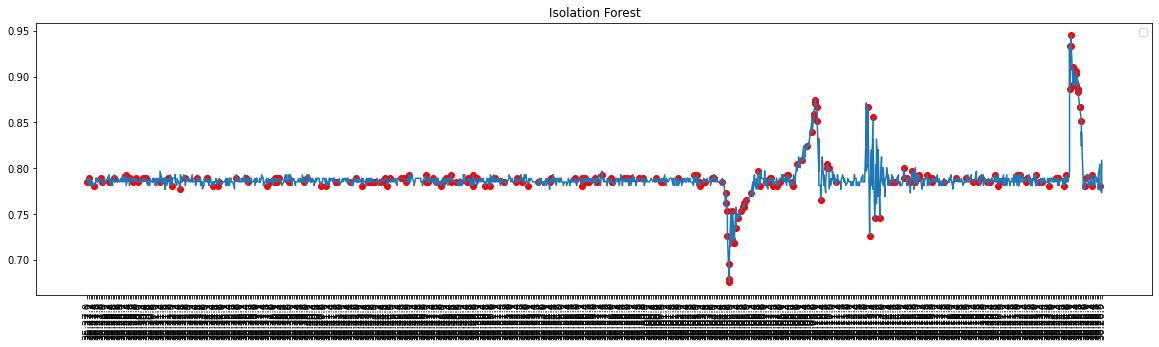

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
pd_anom.sort_values(by=['Pos'],inplace=True)
plt.plot(pd_anom['Pos'],pd_anom['Value'],'-')
plt.scatter(pd_anom.Pos[pd_anom.Anomaly==True], pd_anom.Value[pd_anom.Anomaly==True],marker='o',c='red')
plt.title('Isolation Forest')
plt.xticks(rotation = 90)
plt.legend();

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_true = reference['Anomaly']    # the true anomaly column(0/1)
y_pred = pd_anom['Anomaly']    # the predicted anomaly column

In [0]:
# Find the confusion matrix
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()

In [0]:
print("True negatives :",tn)
print("False positives :",fp)
print("True positives :",fn)
print("False negatives :",tp)

True negatives : 1238
False positives : 233
True positives : 43
False negatives : 6


In [0]:
# Calculate precision and recall

precision = tp/(tp + fp)
recall = tp/(tp + fn) 

In [0]:
precision

0.02510460251046025

In [0]:
recall

0.12244897959183673

In [0]:
f1_score = (2*(precision * recall))/(precision + recall)

In [0]:
f1_score

0.09615384615384616